In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
import os, fnmatch
import pandas as pd
from scipy import interpolate
import warnings
warnings.filterwarnings("ignore")
from scipy import interpolate
from astropy.timeseries import LombScargle
import datetime
import time
from matplotlib import gridspec

# The grid and constant parameters

In [2]:
#HR : 

dlon=2.5
dlat=2.5

#nc=Dataset('j3_fit_params.nc')
#llon=nc['lon'][:]
#llat=nc['lat'][:]
#popt_allboxes_J3=nc['popt'][:]
#nb_timeseries_J3=nc['nb'][:]
#nc.close()


#LR : 
#dlon=10
#dlat=10

lons_boxes=np.arange(-180,180+dlon,dlon)
lats_boxes=np.arange(-60,60+dlat,dlat)
llon,llat=np.meshgrid(lons_boxes,lats_boxes)
llon=0.25*(llon[1:,1:]+llon[1:,:-1]+llon[:-1,1:]+llon[:-1,:-1]) #avg in the middle of boxes because we then average in boxes
llat=0.25*(llat[1:,1:]+llat[1:,:-1]+llat[:-1,1:]+llat[:-1,:-1])



map = Basemap(llcrnrlon=-180,llcrnrlat=-57.5,urcrnrlon=180,urcrnrlat=57.5,
              resolution='c',projection='merc')

# Define the area of interest

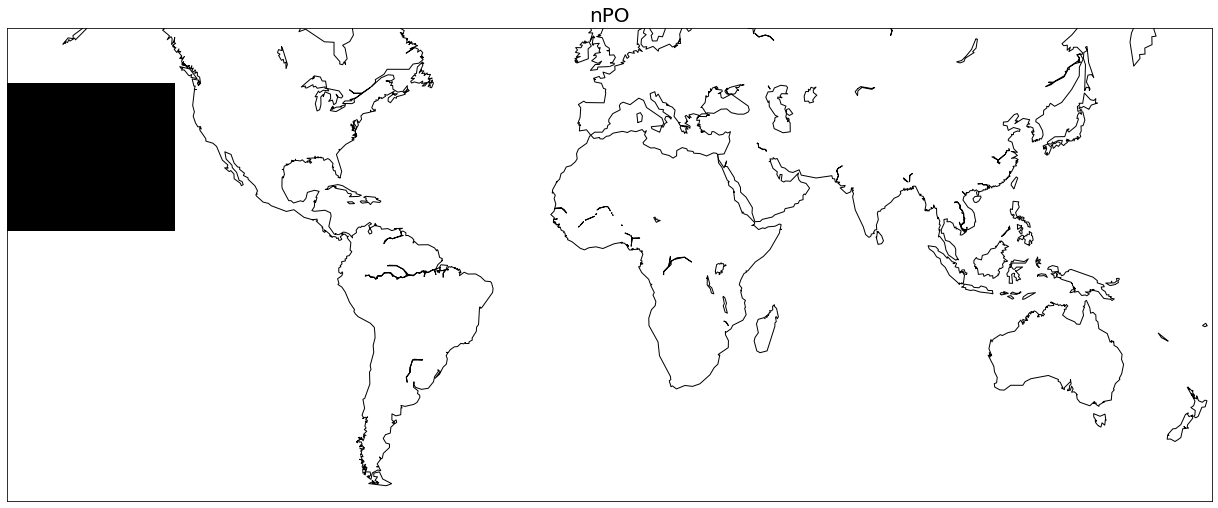

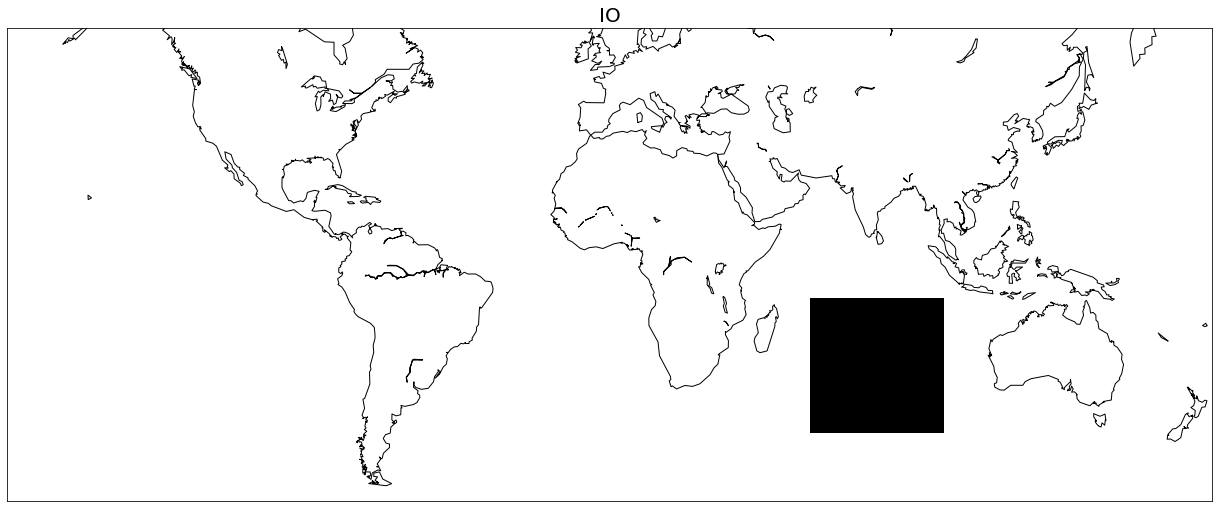

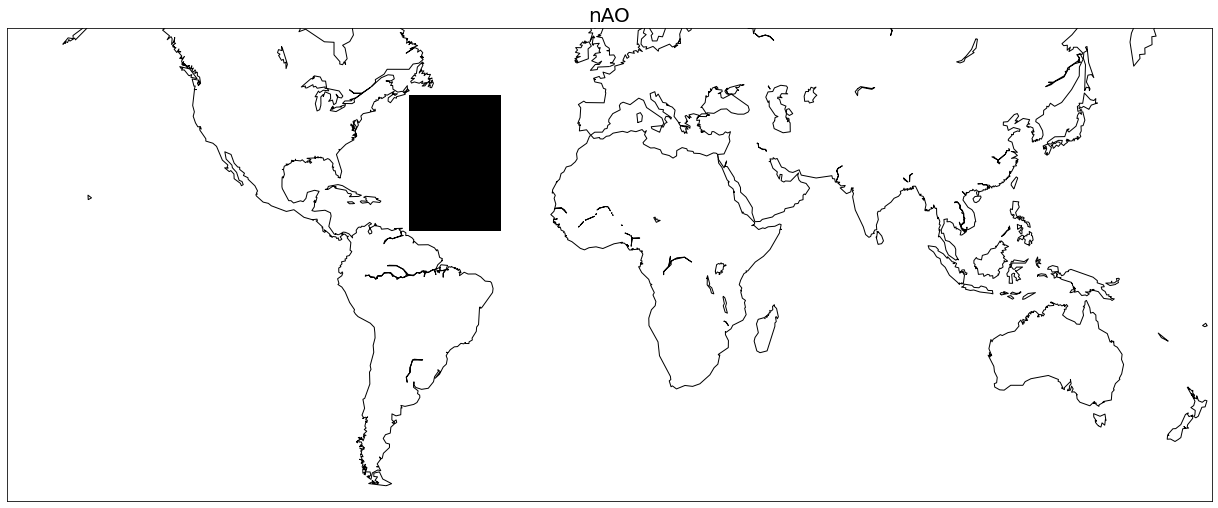

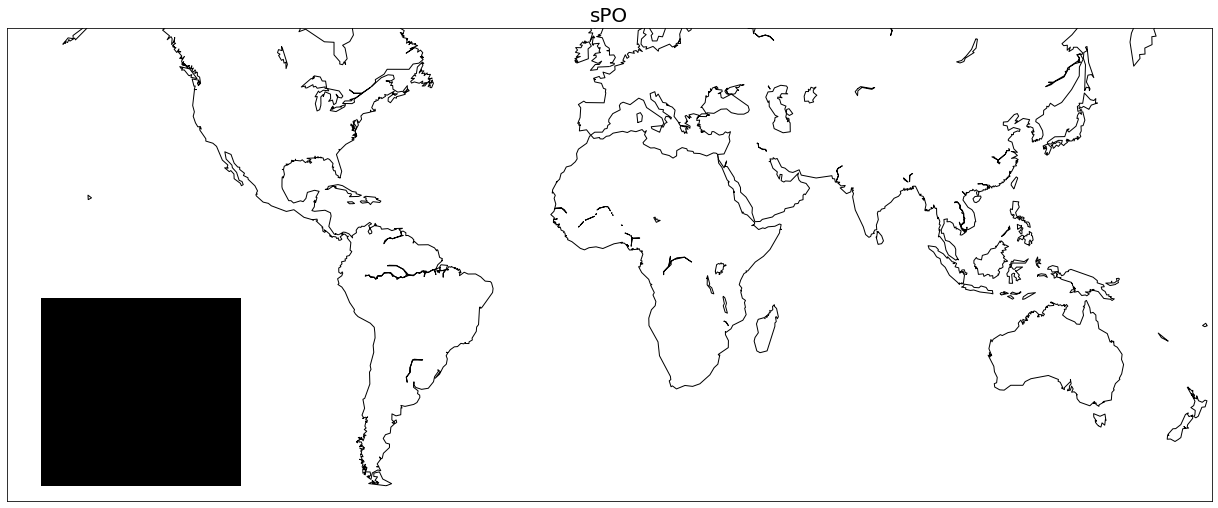

In [3]:
areas=[]
masks={}


#North pacific ocean
take_1=(llat>10)&(llon<-130)&(llat<48.75)
#take_2=(llat<50)
take=take_1#|take_2
name='nPO'
masks[name]=take
areas.append(name)


#IO
take_1=(llat<-10)&(llon<100)
take_2=(llat<-10)&(llon>60)
take_3=(llat>-45)

take=take_1&take_2&take_3
name='IO'
masks[name]=take
areas.append(name)



#nAO
take_1=(llat>10)&(llon<-32)
take_2=(llat<45)&(llon>-60)

take=take_1&take_2
name='nAO'
masks[name]=take
areas.append(name)

#sPO
take_1=(llat>-55)&(llat<-10)&(llon<-110)
take_2=(llat>-55)&(llat<-10)&(llon>-170)

take=take_1&take_2
name='sPO'
masks[name]=take
areas.append(name)



for imask in range(len(areas)):
    fig=plt.figure(figsize=(24,40))
    ax=plt.subplot(411,facecolor='gainsboro')
    plt.title(areas[imask],fontsize=20)
    map.drawcoastlines()
    map.fillcontinents(color='gainsboro',zorder=1)
    xmap,ymap=map(llon,llat)
    pc=plt.pcolormesh(xmap,ymap,masks[areas[imask]],shading='nearest',cmap='binary',vmin=0,vmax=1)
    #pc=plt.contourf(xmap,ymap,toplot,np.arange(0,1.1,0.1),cmap='nipy_spectral')
    plt.show()

### Now define the new grid that takes only the area of interest

In [4]:
area='nPO'
mask=masks[area]

ilat=38 #same as in extract modes

#find the indices of ilons in the area
masks[name]=take
mask_lon=mask[ilat,:] #this will depend on the area, works for nPO
mask_lat=mask[:,0] #this will depend on the area, works for nPO

#this is below the only places we'll consider !
#take only the ilons in the box
ilons=np.arange(llat.shape[1])[mask_lon]
ilats=np.arange(llat.shape[0])[mask_lat]
lon=llon[0,:][mask_lon]
lat=llat[:,0][mask_lat]

lon2,lat2=np.meshgrid(lon,lat)

# Now load the J3 data ($k-\omega$)

In [5]:


#kw calculation
nc=Dataset('./clean_sla_kw_spectra_J3.nc')
llon_J3=nc['lon'][:]
llat_J3=nc['lat'][:]
om_J3=nc['om'][:]/2/np.pi
k_J3=nc['k'][:]/2/np.pi
psdom_J3=nc['Pmarginal_om_sla'][:]
psdk_J3=nc['Pmarginal_k_sla'][:]
#psd_J3_kw=nc['Pw_sla'][:]
nc.close()


#correct the J3 amplitude
correct_j3_norm=(2*20*24*3600)**2/1e4/88
#(2*dt)**2 for the difference in spectra def
#/1e4 for the cm -> m
#/88 for the azim average

psdom_J3=psdom_J3*correct_j3_norm


correct_j3_norm_k=(2*2*10e3)**2/1e4
#(2*dx)**2 for the difference in spectra def
#/1e4 for the cm -> m
psdk_J3=psdk_J3*correct_j3_norm_k

### The fit function

In [6]:
from scipy.optimize import curve_fit
def anal_spectrum(omega,omega0,s,a0):
    return np.log10(a0/(1.+(omega/omega0)**s))


def do_fit(om,psd):
    tmp_mask=np.logical_not(np.isnan(psd))
    popt, pcov = curve_fit(anal_spectrum,om[tmp_mask][1:], #remove the first point where om=0
                           np.log10(psd[tmp_mask][1:]), #do the fit in the logspace
                           p0=[1e-7,2,1e6], #give a first guess
                           bounds=([1e-10,0,1e2], [5e-6, 5, 1e8]), maxfev=5000) #give bounds
    perr = np.sqrt(np.diag(pcov))
    #psd_fit=10**anal_spectrum(om, *popt) #to retrieve the fitted
    
    return popt,perr

## Do the fit in each box

In [33]:
maxfreqfit=1/(1*20*24*3600)
minfreqfit=1/(4*365*24*3600)
masktmp=(om_J3<maxfreqfit)&(om_J3>minfreqfit)


popt_J3=np.full((lat.shape[0],lon.shape[0],3),np.nan)
perr_J3=np.full((lat.shape[0],lon.shape[0],3),np.nan)


for ila in range(len(lat)):
    for ilo in range(len(lon)):
        #do the fit
        #try:
        ilat=ilats[ila]
        ilon=ilons[ilo]
        popt,perr=do_fit(om_J3[masktmp],psdom_J3[ilat,ilon][masktmp])

        #plt.loglog(om_J3[masktmp],psdom_J3[ilat,ilon][masktmp])
        #plt.loglog(om_J3[masktmp],10**anal_spectrum(om_J3[masktmp], *popt))
        #plt.show()

        #except:
        #    popt=np.array([np.nan,np.nan,np.nan])
        #    perr=np.array([np.nan,np.nan,np.nan])    
        #    pass
        
        popt_J3[ila,ilo]=np.copy(popt)
        perr_J3[ila,ilo]=np.copy(perr)
        

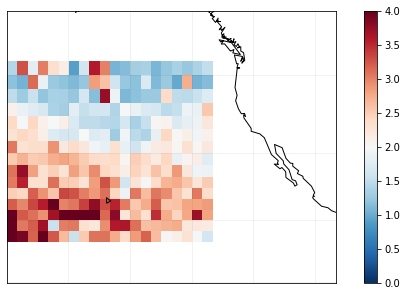

In [8]:
# choose a projection to compute distance in km
mapzoom = Basemap(llcrnrlon=-180,llcrnrlat=0,urcrnrlon=-100,urcrnrlat=55,
              resolution='c',projection='merc')

fig=plt.figure(figsize=(10,5))

ax=plt.subplot(111,facecolor='w')

parallels=np.arange(-90,90,15)
meridians=np.arange(-180,180,15)
mapzoom.drawparallels(parallels,labels=[False,False,False,False],fontsize=15,linewidth=0.1)
mapzoom.drawmeridians(meridians,labels=[False,False,False,False],fontsize=15,linewidth=0.1) 
mapzoom.drawcoastlines()
mapzoom.fillcontinents(color='w',zorder=1)


xmap,ymap=mapzoom(lon2,lat2)
pc=plt.pcolormesh(xmap,ymap,popt_J3[:,:,1],shading='nearest',cmap='RdBu_r',vmin=0,vmax=4)
plt.colorbar()


plt.show()

# To do things cleaner, let's use zonal avg spectra instead

In [9]:
def take_avg_std_basin(VAR,mask_basin):
    if len(VAR.shape)==2:
        VAR=np.where(mask_basin,VAR,np.nan)
        return np.nanmean(VAR,axis=1),np.nanstd(VAR,axis=1)
    elif len(VAR.shape)==3:
        VAR=np.where(mask_basin[:,:,None],VAR,np.nan)
        return np.nanmean(VAR,axis=1),np.nanstd(VAR,axis=1)
    elif len(VAR.shape)==4:
        VAR=np.where(mask_basin[:,:,None,None],VAR,np.nan)
        return np.nanmean(VAR,axis=2),np.nanstd(VAR,axis=2)
    

In [17]:
psdom_J3_basinAVG,psdom_J3_basinSTD=take_avg_std_basin(psdom_J3,mask)
psdom_J3_basinAVG=psdom_J3_basinAVG[mask_lat,:]
psdom_J3_basinSTD=psdom_J3_basinSTD[mask_lat,:]

psdk_J3_basinAVG,psdk_J3_basinSTD=take_avg_std_basin(psdk_J3,mask)
psdk_J3_basinAVG=psdk_J3_basinAVG[mask_lat,:]
psdk_J3_basinSTD=psdk_J3_basinSTD[mask_lat,:]


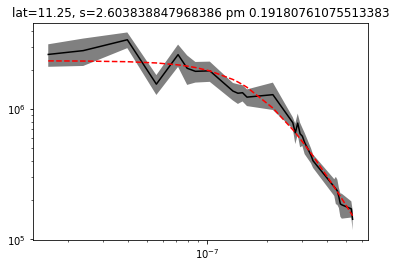

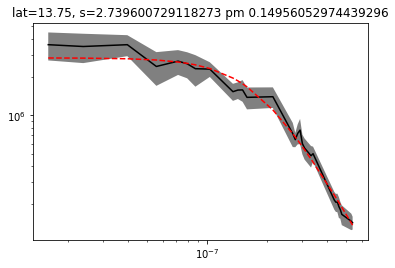

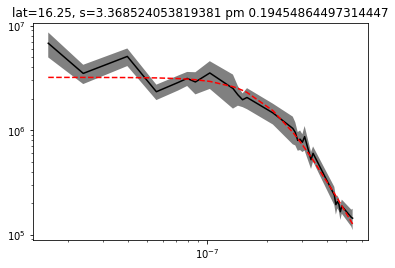

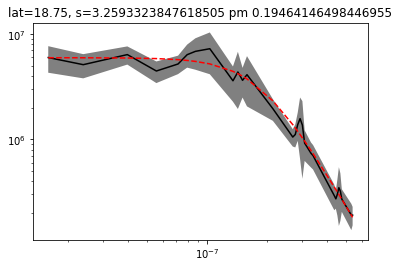

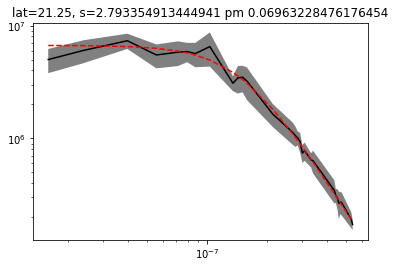

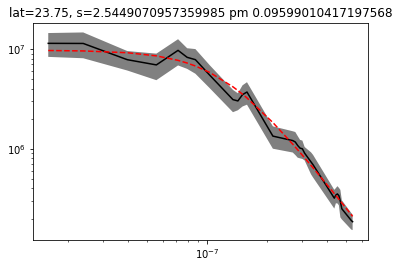

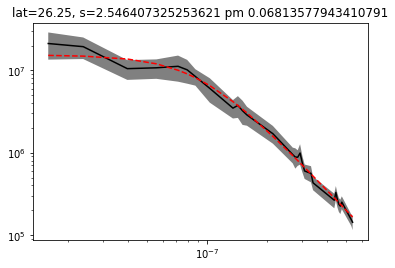

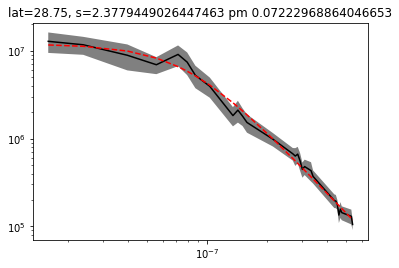

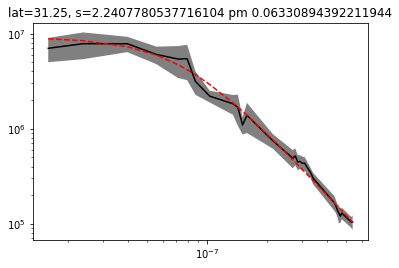

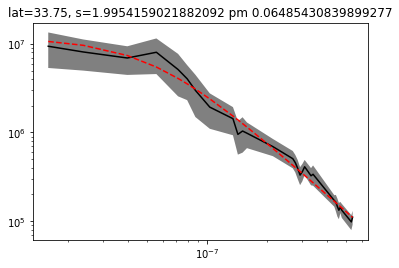

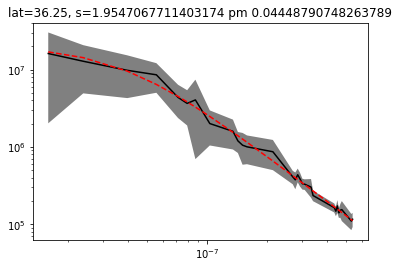

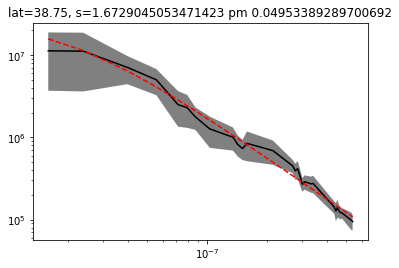

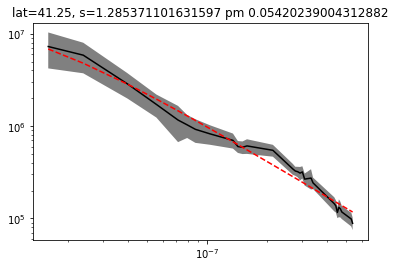

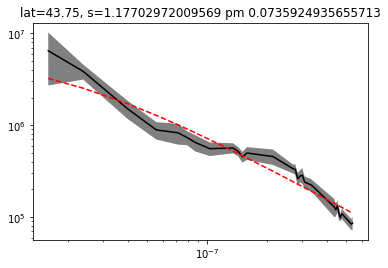

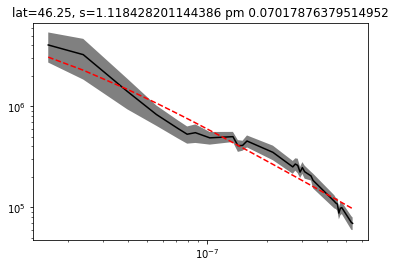

In [36]:



lat_all=[]
s_all=[]
serr_all=[]

om0_all=[]
om0err_all=[]

A_all=[]
Aerr_all=[]

for ilat in range(len(lat)):
    
    maxfreqfit=1/(1*20*24*3600)
    minfreqfit=1/(4*365*24*3600)
    masktmp=(om_J3<maxfreqfit)&(om_J3>minfreqfit)
    
    popt,perr=do_fit(om_J3[masktmp],psdom_J3_basinAVG[ilat][masktmp])
    plt.title('lat={}, s={} pm {}'.format(lat[ilat],popt[1],perr[1]))

    
    plt.fill_between(om_J3[masktmp],
                     psdom_J3_basinAVG[ilat][masktmp]-psdom_J3_basinSTD[ilat][masktmp]/2.,
                     psdom_J3_basinAVG[ilat][masktmp]+psdom_J3_basinSTD[ilat][masktmp]/2.,
                     fc='gray')
    plt.loglog(om_J3[masktmp],psdom_J3_basinAVG[ilat][masktmp],'-k')

    plt.loglog(om_J3[masktmp],10**anal_spectrum(om_J3[masktmp], *popt),'--r')
    plt.show()
    
    lat_all.append(lat[ilat])
    s_all.append(popt[1])
    serr_all.append(perr[1])
    
    om0_all.append(popt[0])
    om0err_all.append(perr[0])
    
    A_all.append(popt[2])
    Aerr_all.append(perr[2])
    
    
lat_all=np.array(lat_all)
s_all=np.array(s_all)
serr_all=np.array(serr_all)

om0_all=np.array(om0_all)
om0err_all=np.array(om0err_all)

A_all=np.array(A_all)
Aerr_all=np.array(Aerr_all)

s=3.26 +- 0.19
s=1.96 +- 0.04
s=1.17 +- 0.07


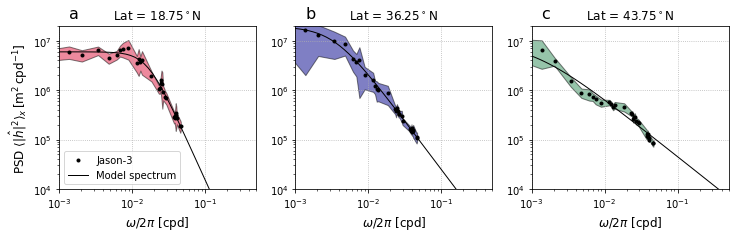

In [29]:
area='nPO'
ilats_show=[3,10,13]#,15]
cols=['crimson','darkblue','seagreen','gold']
fs=12


fig=plt.figure(figsize=(12,3))

for itmp in range(len(ilats_show)):
    ilat=ilats_show[itmp]
    ax=plt.subplot(1,len(ilats_show),itmp+1,facecolor='w')
    plt.yticks(fontsize=fs-2)
    plt.xticks(fontsize=fs-2)

    lets=['a','b','c','d','e','f']
    plt.title(lets[itmp],loc='left',fontsize=fs+4,y=1.01,x=0.05) 

    ## some spectra as examples

    maxfreqfit=1/(1*20*24*3600)
    minfreqfit=1/(10*365*24*3600)
    masktmp=(om_J3<maxfreqfit)&(om_J3>minfreqfit)


    popt,perr=do_fit(om_J3[masktmp],psdom_J3_basinAVG[ilat][masktmp])
    plt.fill_between(om_J3[masktmp]*24*3600,
                     psdom_J3_basinAVG[ilat][masktmp]-psdom_J3_basinSTD[ilat][masktmp]/2.,
                     psdom_J3_basinAVG[ilat][masktmp]+psdom_J3_basinSTD[ilat][masktmp]/2.,
                     #'-k',
                     facecolor=cols[itmp], #'None' for a transparent one
                        edgecolor='k', #'None' for no line
                             linewidth=1,
                             alpha=0.5)
    plt.loglog(om_J3[masktmp]*24*3600,psdom_J3_basinAVG[ilat][masktmp],'.k',lw=2,label='Jason-3')#,label='zonAVG J3, s={:.2f} +- {:.2f}'.format(popt[1],perr[1]))
    
    


    plt.grid(ls=':')

    ax.set_xlim(1e-3,5e-1)

    ax.set_ylim(1e4,2e7)

    plt.xlabel(r'$\omega /2\pi$ [cpd]',fontsize=fs)
    if itmp==0:plt.ylabel(r'PSD $\langle|\hat h|^2\rangle_x\, {\rm [m^2\,cpd^{-1}]}$',fontsize=fs)




    #show swot




    #plt.fill_between(om_swot[pass_wanted][2:]/2/np.pi*24*3600,
    #                 Pw_om_swot_avg_area_allpasses[2:,ilat]-Pw_om_swot_std_area_allpasses[2:,ilat]/2.,
    #                 Pw_om_swot_avg_area_allpasses[2:,ilat]+Pw_om_swot_std_area_allpasses[2:,ilat]/2.,
    #                 '-k',
    #                 facecolor=cols[itmp], #'None' for a transparent one
    #                    edgecolor='k', #'None' for no line
    #                         linewidth=1,
    #                         alpha=0.5)



    #plt.loglog(om_swot[pass_wanted][2:]/2/np.pi*24*3600,Pw_om_swot_avg_area_allpasses[2:,ilat],'xk',ms=10,lw=2,
    #          label='SWOT KaRIn')

    plt.title('Lat = {}'.format(lat[ilat])+r'$^\circ$N')

    om_tmp=np.logspace(-8,-5,50)
    plt.loglog(om_tmp*24*3600,10**anal_spectrum(om_tmp, *popt),'-k',lw=1,label='Model spectrum')
    print('s={:.2f} +- {:.2f}'.format(popt[1],perr[1]))
    
    #if itmp==2:
    #    plt.loglog(om_tmp*24*3600,10**anal_spectrum(om_tmp, popt[0]*2,2,popt[2]),'--k',lw=1)
    
        
    
    
    if itmp==0:plt.legend()
#plt.savefig('nPO_spectra_j3-swot.png',dpi=200,bbox_inches='tight')

plt.show()

In [30]:
ilat=10
nc_save=Dataset('./j3_ok_spectrum_tmp.nc', 'w',  format='NETCDF4_CLASSIC')

nc_save.createDimension('freq', len(om_J3))


freq_var = nc_save.createVariable('freq', np.float32, ('freq'))
psd_var = nc_save.createVariable('psd', np.float32, ('freq'))
psd_std_var = nc_save.createVariable('psd_std', np.float32, ('freq'))
freq_var[:]=om_J3
psd_var[:]=psdom_J3_basinAVG[ilat]
psd_std_var[:]=psdom_J3_basinSTD[ilat]
nc_save.close()

# Now load everything else and vg in the are to have other quantities

In [31]:
# Coriolis Parameter
om = 7.2921e-5 #rad/s
Rt = 6371e3 
f0 = 2*om*np.sin(np.deg2rad(llat))
beta = 2*om*np.cos(np.deg2rad(llat))/Rt

# Load the velocity modes from ECCO, and the associated quantities

See MODE_DECOMPOSITION.py script

In [32]:
#read the netcdf
nc=Dataset('./ecco_uv_mean.nc')
lon_ecco=nc['lon'][:]
lat_ecco=nc['lat'][:]
z_ecco=nc['z'][:]
u_ecco_mean=nc['u'][:]
v_ecco_mean=nc['v'][:]
nc.close()

U_ecco_mean=np.sqrt(u_ecco_mean**2+v_ecco_mean**2)

nc=Dataset('./ecco_TS_mean.nc')
lon_ecco=nc['lon'][:]
lat_ecco=nc['lat'][:]
z_ecco=nc['z'][:]
T_ecco_mean=nc['T'][:]
S_ecco_mean=nc['S'][:]
nc.close()


# Load velocity modes

# LR : straightforward

#nc=Dataset('./MODE_DECOMPOSITION/velocity_modes_LR.nc')
#hn_all=nc['hn'][:]
#cn_all=nc['cn'][:]
#H_all=nc['H'][:]
#nc.close()


#HR : combine multiple files

import os, fnmatch
path_modal='./'
files=fnmatch.filter(os.listdir(path_modal), 'velocity_modes_HR_*')

print('all {} files:'.format(len(files)))
print('_______________________________________________________________')
for ifile in range(len(files)):
    print(files[ifile])



    nc=Dataset(path_modal+files[ifile])
    hn_all_ifile=nc['hn'][:]
    cn_all_ifile=nc['cn'][:]
    H_all_ifile=nc['H'][:]
    nc.close() 

    if ifile==0:
        hn_all=np.full(hn_all_ifile.shape,np.nan)
        cn_all=np.full(cn_all_ifile.shape,np.nan)
        H_all=np.full(H_all_ifile.shape,np.nan)

    hn_all=np.where(~np.isnan(hn_all_ifile),hn_all_ifile,hn_all)
    cn_all=np.where(~np.isnan(cn_all_ifile),cn_all_ifile,cn_all)
    H_all=np.where(~np.isnan(H_all_ifile),H_all_ifile,H_all)
    
    
nmodes=len(hn_all)
z_modes=0.5*(z_ecco[1:]+z_ecco[:-1])

#compute the First baroclinic radius using cn
Rd_modes=cn_all[1]/np.abs(f0)

# compute modal amplitude
dz_modes=-np.diff(z_ecco)

#to check with chelton
#ax=plt.subplot(111)
#plt.plot(llat[:,0],Rd_modes[:,0]/1e3)
#plt.plot(llat[:,0],Rd_Chelton_i[:,0])
#ax.set_ylim(0,100)
#plt.show()


## Now average in boxes
#the function to box avg

def taking_box(iboxlon,iboxlat,lons_boxes,lats_boxes):
    
    minlon=lons_boxes[iboxlon]
    maxlon=lons_boxes[iboxlon+1]
    minlat=lats_boxes[iboxlat]
    maxlat=lats_boxes[iboxlat+1]

    lon_ecco_flat,lat_ecco_flat=np.ravel(lon_ecco),np.ravel(lat_ecco)
    take_box=(lon_ecco_flat<maxlon)&(lon_ecco_flat>minlon)&(lat_ecco_flat<maxlat)&(lat_ecco_flat>minlat)

    return take_box

def avg_std_med_box_var(VAR,take_box):

    VAR_resh=np.reshape(VAR,(VAR.shape[0],take_box.shape[0]))

    VAR_box=VAR_resh[:,take_box]

    VAR_avg_box=np.nanmean(VAR_box,axis=1)
    VAR_std_box=np.nanstd(VAR_box,axis=1)
    VAR_med_box=np.nanmedian(VAR_box,axis=1)
    
    plotting=False
    if plotting==True:
        
        plt.plot(VAR_box,z_ecco,'--k',lw=0.1)
        plt.plot(VAR_avg_box,z_ecco)
        plt.plot(VAR_avg_box+VAR_std_box,z_ecco,'-r')
        plt.plot(VAR_avg_box-VAR_std_box,z_ecco,'-r')
        plt.show()
    
    return VAR_avg_box,VAR_std_box,VAR_med_box




# First re-compute the avg buoyancy similarly as in the modal decomposition

T_ecco_mean_i=np.full((u_ecco_mean.shape[0],llon.shape[0],llon.shape[1]),np.nan)
S_ecco_mean_i=np.full((u_ecco_mean.shape[0],llon.shape[0],llon.shape[1]),np.nan)


for iboxlon in range(llon.shape[1]):
    print(100*iboxlon/llon.shape[1],'%')
    for iboxlat in range(llat.shape[0]):
        take_box=taking_box(iboxlon,iboxlat,lons_boxes,lats_boxes)
        T_ecco_mean_i[:,iboxlat,iboxlon],VAR_std_box,VAR_med_box=avg_std_med_box_var(T_ecco_mean,take_box)
        S_ecco_mean_i[:,iboxlat,iboxlon],VAR_std_box,VAR_med_box=avg_std_med_box_var(S_ecco_mean,take_box)
        

import gsw as gsw
P_ecco_i=gsw.p_from_z(z_ecco[:,None,None],lat_ecco[None,:,:])
#compute N2
z_ecco_N2=0.5*(z_ecco[1:]+z_ecco[:-1])
N2_ecco_mean_i=np.full((z_ecco_N2.shape[0],S_ecco_mean_i.shape[1],S_ecco_mean_i.shape[2]),np.nan)
for ila in range(S_ecco_mean_i.shape[1]):
    for ilo in range(S_ecco_mean_i.shape[2]):
        N2_ecco_mean_i[:,ila,ilo],blc=gsw.Nsquared(S_ecco_mean_i[:,ila,ilo],
                                        T_ecco_mean_i[:,ila,ilo],
                                        P_ecco_i[:,ila,ilo],
                                        lat_ecco[ila,ilo])
sigma0_ecco_mean_i = gsw.sigma0(S_ecco_mean_i,T_ecco_mean_i)+1e3
ga=9.81
b_ecco_mean_i=-ga*sigma0_ecco_mean_i/np.nanmean(sigma0_ecco_mean_i,axis=0)




# The do in another way
# in each box, project every velocity profile, 
# and then store the U_n for each box as a list (so we can compute averages, and std for the BC and BT values)


def project_all_U_box(VAR,take_box):

    #put on the correct z-grid
    VAR=0.5*(VAR[1:]+VAR[:-1])

    VAR_resh=np.reshape(VAR,(VAR.shape[0],take_box.shape[0]))
    #the list with all velocity profiles
    VAR_box=VAR_resh[:,take_box]

    #project all the velocity profiles on the average modes of the box
    U_n_box=(1/H_all[iboxlat,iboxlon])*np.nansum(VAR_box[None,:,:]*hn_all[:,:,iboxlat,iboxlon][:,:,None]*dz_modes[None,:,None],axis=1)

    #compute the statistics of U_n in this box
    U_n_box_avg=np.nanmean(U_n_box,axis=1)
    U_n_box_med=np.nanmedian(U_n_box,axis=1)
    U_n_box_std=np.nanstd(U_n_box,axis=1)
    U_n_box_N=U_n_box.shape[1]

    #compute also the average velocity profile, and the average modal projection from this one to have something similar as previously
    VAR_avg_box=np.nanmean(VAR_box,axis=1)

    #plotting=False
    #if plotting==True:
    #plt.plot(VAR_box,z_modes,'--k',lw=0.1)
    #plt.show()

    return VAR_avg_box,U_n_box_avg,U_n_box_med,U_n_box_std,U_n_box_N


U_ecco_mean_i=np.full((u_ecco_mean.shape[0]-1,llon.shape[0],llon.shape[1]),np.nan)
U_n_avg_all=np.full(cn_all.shape,np.nan)
U_n_med_all=np.full(cn_all.shape,np.nan)
U_n_std_all=np.full(cn_all.shape,np.nan)
U_n_N_all=np.full(H_all.shape,np.nan)


for iboxlon in range(llon.shape[1]):
    print(100*iboxlon/llon.shape[1],'%')
    for iboxlat in range(llat.shape[0]):

        take_box=taking_box(iboxlon,iboxlat,lons_boxes,lats_boxes)
        VAR_avg_box,U_n_box_avg,U_n_box_med,U_n_box_std,U_n_box_N=project_all_U_box(U_ecco_mean,take_box)


        U_ecco_mean_i[:,iboxlat,iboxlon]=VAR_avg_box
        U_n_avg_all[:,iboxlat,iboxlon]=U_n_box_avg
        U_n_med_all[:,iboxlat,iboxlon]=U_n_box_med
        U_n_std_all[:,iboxlat,iboxlon]=U_n_box_std
        U_n_N_all[iboxlat,iboxlon]=U_n_box_N
        
        
        
# Project the velocity on average U_n

U_modes=U_n_avg_all[:,None,:,:]*hn_all[:,:]
U_sum_modes=np.nansum(U_modes,axis=0)

all 5 files:
_______________________________________________________________
velocity_modes_HR_1.nc
velocity_modes_HR_5.nc
velocity_modes_HR_4.nc
velocity_modes_HR_3.nc
velocity_modes_HR_2.nc
0.0 %
0.6944444444444444 %
1.3888888888888888 %
2.0833333333333335 %
2.7777777777777777 %
3.4722222222222223 %
4.166666666666667 %
4.861111111111111 %
5.555555555555555 %
6.25 %
6.944444444444445 %
7.638888888888889 %
8.333333333333334 %
9.027777777777779 %
9.722222222222221 %
10.416666666666666 %
11.11111111111111 %
11.805555555555555 %
12.5 %
13.194444444444445 %
13.88888888888889 %
14.583333333333334 %
15.277777777777779 %
15.972222222222221 %
16.666666666666668 %
17.36111111111111 %
18.055555555555557 %
18.75 %
19.444444444444443 %
20.13888888888889 %
20.833333333333332 %
21.52777777777778 %
22.22222222222222 %
22.916666666666668 %
23.61111111111111 %
24.305555555555557 %
25.0 %
25.694444444444443 %
26.38888888888889 %
27.083333333333332 %
27.77777777777778 %
28.47222222222222 %
29.16666666666

KeyboardInterrupt: 

##### Now clean the map by averaging around missing points

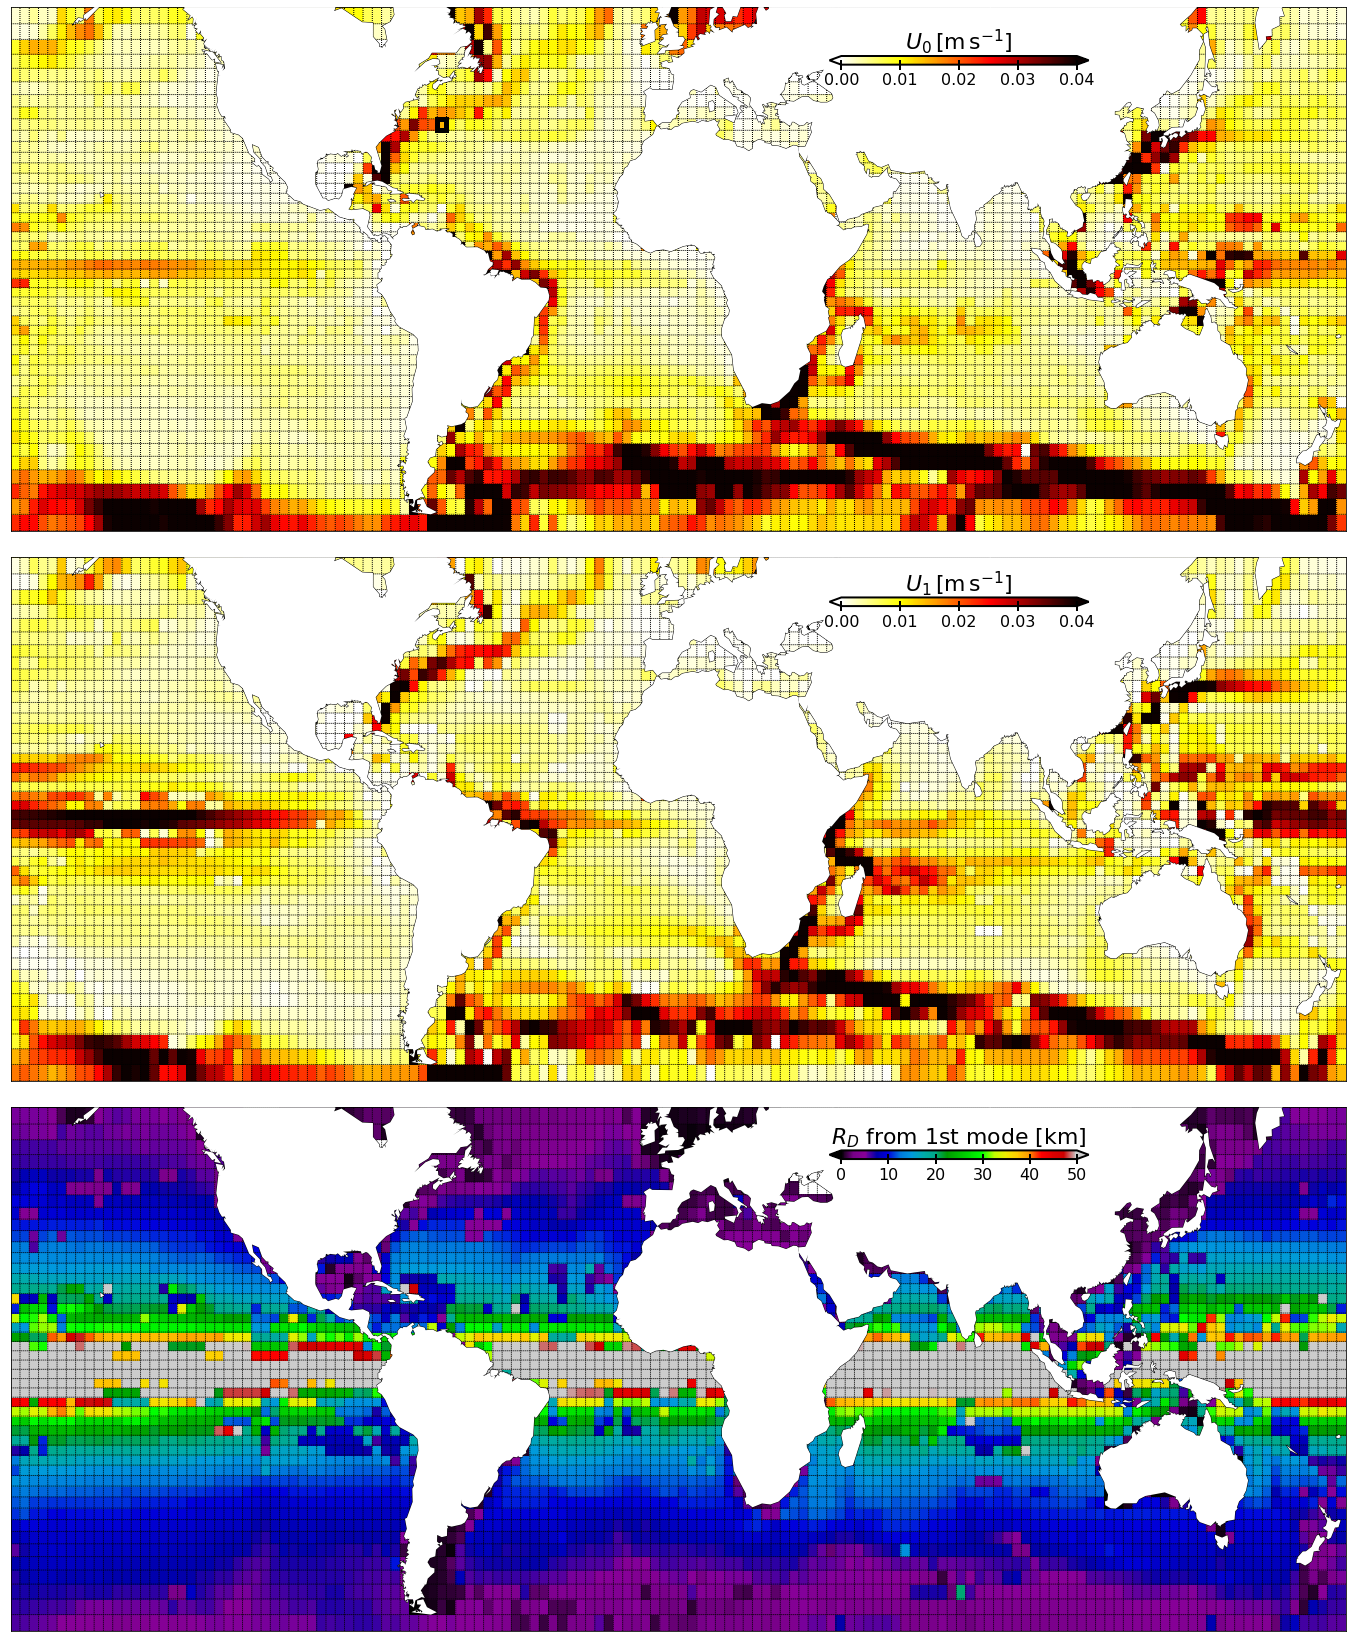

In [23]:
#average with values at the same latitude to fill missing values

def zonal_avg(VAR,dlon_avg):
    #dlon_avg=4 #the number of point on the right and on the left to consider for the average


    VAR_corrected=np.copy(VAR)

    for ilon in range(VAR.shape[1]):
        

        if ilon<dlon_avg : VAR_to_avg=VAR[:,:(ilon+dlon_avg)]
        elif ilon>VAR.shape[1]-dlon_avg : VAR_to_avg=VAR[:,(ilon-dlon_avg):]   
        else : VAR_to_avg=VAR[:,(ilon-dlon_avg):(ilon+dlon_avg)]
        VAR_zonal_avg=np.nanmean(VAR_to_avg,axis=1)

        VAR_corrected[:,ilon]=np.where(np.isnan(VAR_corrected[:,ilon]),VAR_zonal_avg[:],VAR_corrected[:,ilon])

        
        #plt.plot(VAR[:,ilon],'o-')
        #plt.plot(VAR_zonal_avg[:],'o-')
        #plt.plot(VAR_corrected[:,ilon],'o-')
        #plt.show()
        
    return VAR_corrected
dlon_avg=6

Rd_modes_ok=zonal_avg(Rd_modes,dlon_avg)
U_n_avg_all_ok=np.full(U_n_avg_all.shape,np.nan)
U_n_std_all_ok=np.full(U_n_avg_all.shape,np.nan)
for imode in range(len(U_n_avg_all)):
    
    U_n_avg_all_ok[imode]=zonal_avg(U_n_avg_all[imode],dlon_avg)
    U_n_std_all_ok[imode]=zonal_avg(U_n_std_all[imode],dlon_avg)
    
    
U_n_avg_all_ok=np.abs(U_n_avg_all_ok)


cmap='hot_r'

fig=plt.figure(figsize=(24,40))

ax=plt.subplot(411,facecolor='w')

parallels=np.arange(-60,90,dlon)
meridians=np.arange(-180,180,dlat)
map.drawparallels(parallels,labels=[False,False,False,False],fontsize=15,linewidth=1)
map.drawmeridians(meridians,labels=[False,False,False,False],fontsize=15,linewidth=1) 
map.drawcoastlines(zorder=100)
map.fillcontinents(color='w',zorder=100)


xmap,ymap=map(llon,llat)
pc=plt.pcolormesh(xmap,ymap,U_n_avg_all_ok[0],shading='nearest',cmap=cmap,vmin=0,vmax=0.04)


cbar_ax = fig.add_axes([0.6, 0.86, 0.15, 0.003])
cbar=fig.colorbar(pc, cax=cbar_ax,extend='both',orientation='horizontal')#,ticks=np.arange(0,6,1))
cbar_ax.set_title(r'$U_0\,{\rm [m\,s^{-1}]}$', fontsize=22, x=0.5,y=1.02)
cbar.ax.yaxis.set_offset_position('right')
#cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.outline.set_linewidth(2)
cbar_ax.tick_params(direction='inout',width=2,length=10,labelsize=16)

def show_loc_rect(ilon,ilat,ax):
    xll,yll=map(lons_boxes[ilon],lats_boxes[ilat])
    xur,yur=map(lons_boxes[ilon+1],lats_boxes[ilat+1])
    dxrect=xur-xll
    dyrect=yur-yll
    x0rect=xll#0.5*(xll+xur)
    y0rect=yll#0.5*(yll+yur)
    import matplotlib.patches as patches
    rect = patches.Rectangle((x0rect,y0rect), dxrect, dyrect, linewidth=5, edgecolor='k', facecolor='none',zorder=2000)
    ax.add_patch(rect)


#GS
ilon=46
ilat=38

#NPO
#ilon=3
#ilat=9

show_loc_rect(ilon,ilat,ax)


ax=plt.subplot(412,facecolor='w')

parallels=np.arange(-60,90,dlon)
meridians=np.arange(-180,180,dlat)
map.drawparallels(parallels,labels=[False,False,False,False],fontsize=15,linewidth=1)
map.drawmeridians(meridians,labels=[False,False,False,False],fontsize=15,linewidth=1) 
map.drawcoastlines(zorder=100)
map.fillcontinents(color='w',zorder=100)

pc=plt.pcolormesh(xmap,ymap,U_n_avg_all_ok[1],shading='nearest',cmap=cmap,vmin=0,vmax=0.04)




cbar_ax = fig.add_axes([0.6, 0.672, 0.15, 0.003])
cbar=fig.colorbar(pc, cax=cbar_ax,extend='both',orientation='horizontal')#,ticks=np.arange(0,6,1))
cbar_ax.set_title(r'$U_1\,{\rm [m\,s^{-1}]}$', fontsize=22, x=0.5,y=1.02)
cbar.ax.yaxis.set_offset_position('right')
#cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.outline.set_linewidth(2)
cbar_ax.tick_params(direction='inout',width=2,length=10,labelsize=16)






ax=plt.subplot(413,facecolor='w')

parallels=np.arange(-60,90,dlon)
meridians=np.arange(-180,180,dlat)
map.drawparallels(parallels,labels=[False,False,False,False],fontsize=15,linewidth=1)
map.drawmeridians(meridians,labels=[False,False,False,False],fontsize=15,linewidth=1) 
map.drawcoastlines(zorder=100)
map.fillcontinents(color='w',zorder=100)


pc=plt.pcolormesh(xmap,ymap,Rd_modes_ok/np.pi/1e3,shading='nearest',cmap='nipy_spectral',vmin=0,vmax=50)




cbar_ax = fig.add_axes([0.6, 0.48, 0.15, 0.003])
cbar=fig.colorbar(pc, cax=cbar_ax,extend='both',orientation='horizontal')#,ticks=np.arange(0,6,1))
cbar_ax.set_title(r'$R_D$ from 1st mode [km]', fontsize=22, x=0.5,y=1.02)
cbar.ax.yaxis.set_offset_position('right')
#cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.outline.set_linewidth(2)
cbar_ax.tick_params(direction='inout',width=2,length=10,labelsize=16)




plt.subplots_adjust(hspace=0.05)
    
#plt.savefig('./result_modes.png',dpi=300,bbox_inches='tight')

plt.show()

# Estimate the $\xi^{-1}$ parameter using modal decomposition

Following the modal decomposition of continuously stratified QG model, $\xi^{-1}=\beta R_D^2/(2\Delta U_1)$

In [24]:
xi_inv=beta*(Rd_modes_ok/np.pi)**2/(2*U_n_avg_all_ok[1])

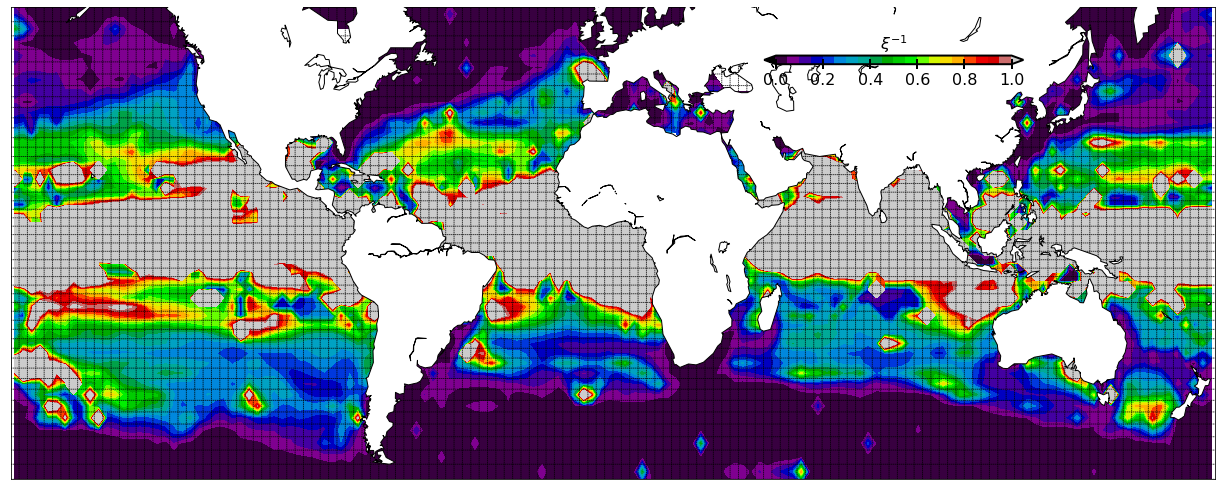

In [25]:
# choose a projection to compute distance in km


fig=plt.figure(figsize=(24,40))

ax=plt.subplot(411,facecolor='w')

parallels=np.arange(-60,90,dlon)
meridians=np.arange(-180,180,dlat)
map.drawparallels(parallels,labels=[False,False,False,False],fontsize=15,linewidth=1)
map.drawmeridians(meridians,labels=[False,False,False,False],fontsize=15,linewidth=1) 
map.drawcoastlines(zorder=200)
map.fillcontinents(color='w',zorder=100)


xmap,ymap=map(llon,llat)
#pc=plt.pcolormesh(xmap,ymap,xi_inv,shading='nearest',cmap='nipy_spectral',vmin=0,vmax=1)
pc=plt.contourf(xmap,ymap,xi_inv,np.linspace(0,1.,21),cmap='nipy_spectral',extend='both')

cbar_ax = fig.add_axes([0.6, 0.86, 0.15, 0.003])
cbar=fig.colorbar(pc, cax=cbar_ax,extend='both',orientation='horizontal',ticks=np.arange(0,1.1,0.2))
cbar_ax.set_title(r'$\xi^{-1}$', fontsize=16, x=0.5,y=1.02)
cbar.ax.yaxis.set_offset_position('right')
#cbar.formatter.set_powerlimits((0, 0))
cbar.update_ticks()
cbar.outline.set_linewidth(2)
cbar_ax.tick_params(direction='inout',width=2,length=10,labelsize=16)

plt.show()

# the figure recap of these ECCO-derived parameters

In [26]:
def show_loc_mask(imask,ax,name,map):
    xll,yll=map(np.min(llon[masks[areas[imask]]]),np.min(llat[masks[areas[imask]]]))
    xur,yur=map(np.max(llon[masks[areas[imask]]]),np.max(llat[masks[areas[imask]]]))
    dxrect=xur-xll
    dyrect=yur-yll
    x0rect=xll#0.5*(xll+xur)
    y0rect=yll#0.5*(yll+yur)
    import matplotlib.patches as patches
    rect = patches.Rectangle((x0rect,y0rect), dxrect, dyrect, linewidth=2,
                             linestyle='--', edgecolor='k', facecolor='none',zorder=2)
    ax.add_patch(rect)
    
    ax.annotate(name,xy=(xll,yur-200e3) ,textcoords='data',fontsize=fs-2,zorder=1000,color='k',ha='left',va='top')

    
def show_loc_mask_noname(imask,ax,name,map):
    xll,yll=map(np.min(llon[masks[areas[imask]]]),np.min(llat[masks[areas[imask]]]))
    xur,yur=map(np.max(llon[masks[areas[imask]]]),np.max(llat[masks[areas[imask]]]))
    dxrect=xur-xll
    dyrect=yur-yll
    x0rect=xll#0.5*(xll+xur)
    y0rect=yll#0.5*(yll+yur)
    import matplotlib.patches as patches
    rect = patches.Rectangle((x0rect,y0rect), dxrect, dyrect, linewidth=2,
                             linestyle='--', edgecolor='k', facecolor='none',zorder=2)
    ax.add_patch(rect)
    
    #ax.annotate(name,xy=(xll,yur-200e3) ,textcoords='data',fontsize=fs-2,zorder=1000,color='k',ha='left',va='top')


In [27]:
# create a colormap for the ratio

import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from collections import OrderedDict
ncol=500
nsample=int(ncol/4) #divide in two at 1/4 of the range
Blues = cm.get_cmap('hot_r', ncol)
Colors_Blues = Blues(np.linspace(0, 1, ncol))
mycolors=np.zeros(Colors_Blues.shape)
Reds = cm.get_cmap('Blues', ncol)
Colors_Reds = Reds(np.linspace(0, 1, nsample+1))
mycolors[nsample:]=Colors_Blues[:-nsample,:]
mycolors[:nsample+1]=Colors_Reds[::-1]
MYCMP = ListedColormap(mycolors)

nPO
IO
nAO
sPO
nPO
IO
nAO
nPO
IO
nAO


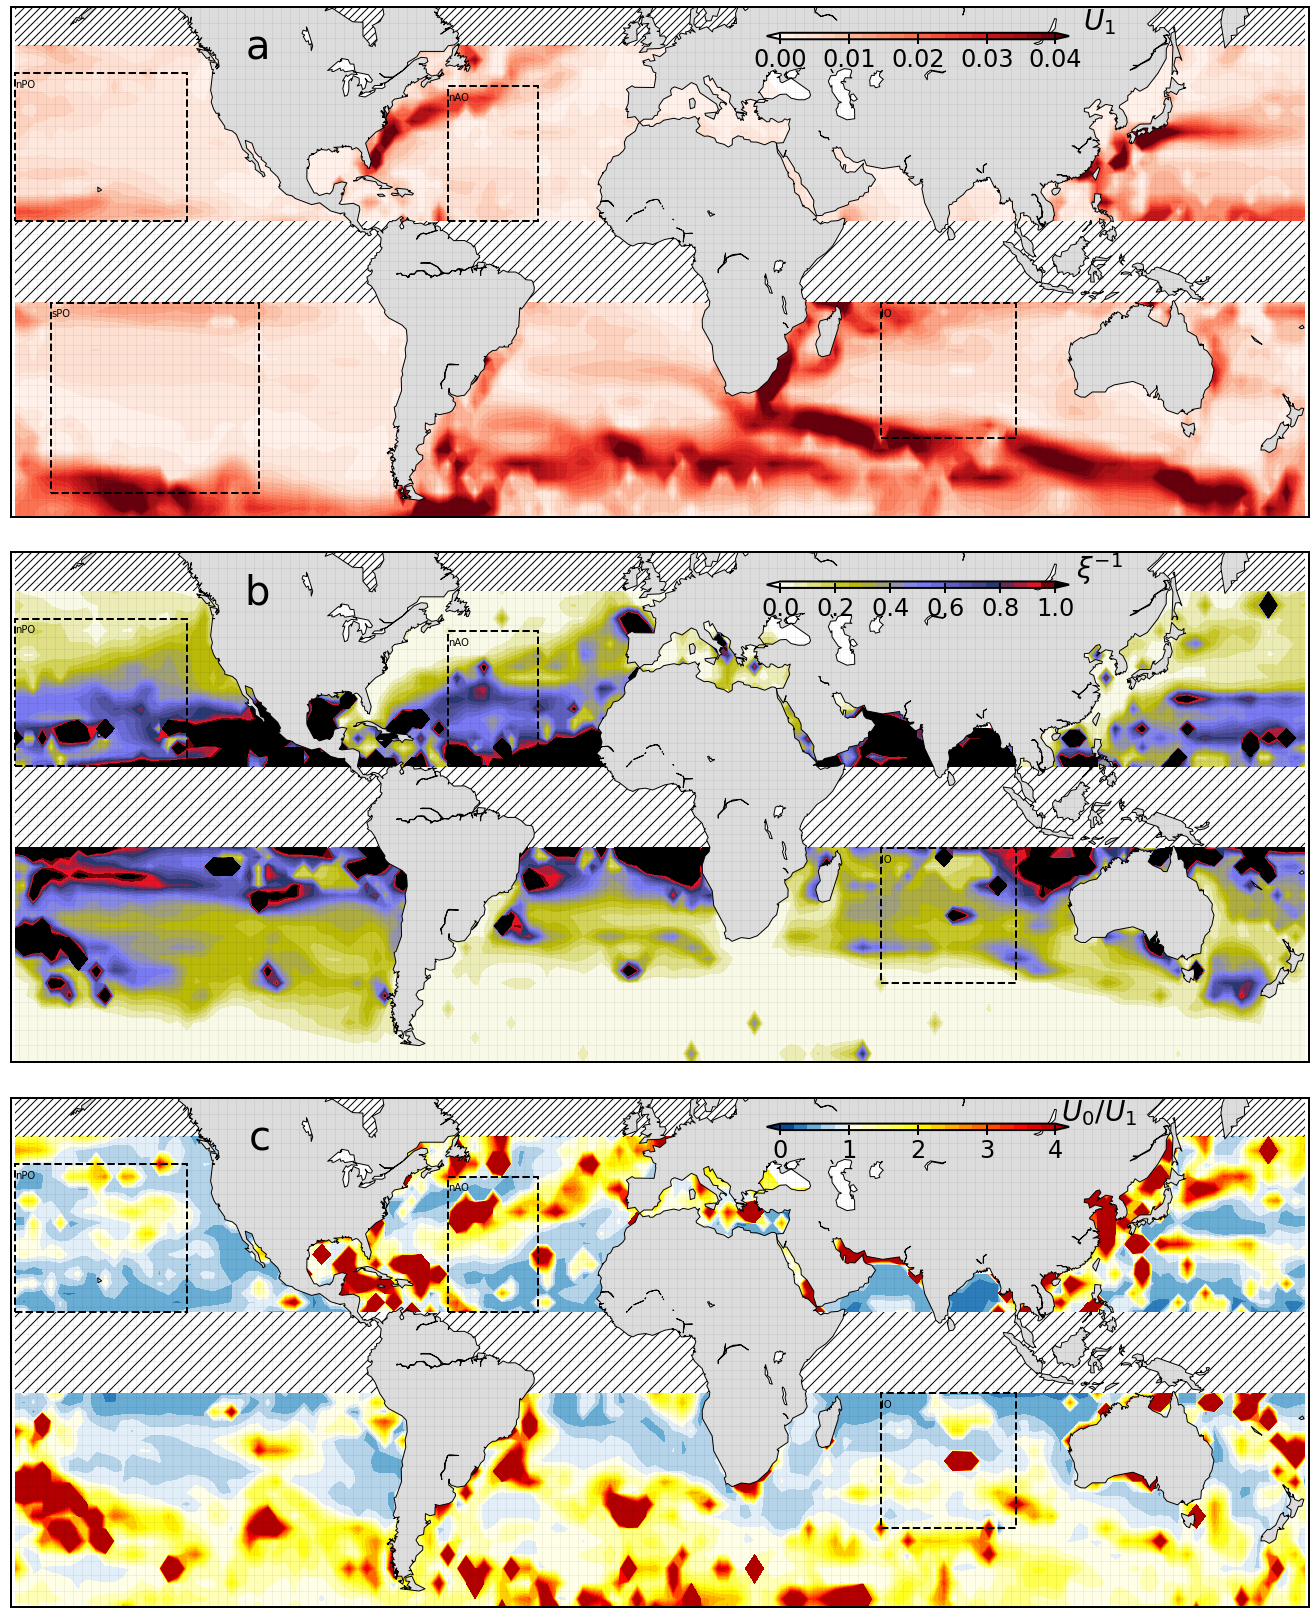

In [32]:
fig=plt.figure(figsize=(28,30))
gs = gridspec.GridSpec(3,12)
fs=12
lets=['a','b','c','(d)','(e)','(f)']

map = Basemap(llcrnrlon=-180,llcrnrlat=-57.5,urcrnrlon=180,urcrnrlat=57.5,
              resolution='c',projection='merc')

#m2 = Basemap(projection='moll',lon_0=0,resolution='c')
xmap,ymap=map(llon,llat)

for imap in range(3):
    
    ax=plt.subplot(gs[imap,:10],facecolor='w')
    
    
    plt.annotate(lets[imap], xy=(0.2, 0.88),
            xycoords='axes fraction',ha='right', va='bottom',
            size=40)
    
    ax.spines['top'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    parallels=np.arange(-60,90,dlon)
    meridians=np.arange(-180,180,dlat)
    map.drawparallels(parallels,labels=[False,False,False,False],fontsize=15,linewidth=0.1)
    map.drawmeridians(meridians,labels=[False,False,False,False],fontsize=15,linewidth=0.1) 
    map.drawcoastlines(zorder=200)
    map.fillcontinents(color='gainsboro',zorder=2)
    
    
    plt.contourf(xmap,ymap,llat_J3,[-11.25,11.25], hatches=['//'],colors='none',rasterized=True,zorder=2)
    plt.contourf(xmap,ymap,llat_J3,[51.25,60], hatches=['///'],colors='none',rasterized=True,zorder=2)

    only_mid=(np.abs(llat)<10)|(llat>51.25)
    
    if imap==0:
        
        
        
        
        toplot=np.where(only_mid,np.nan,U_n_avg_all_ok[1])
        pc=plt.contourf(xmap,ymap,toplot,np.linspace(0,0.04,21),cmap='Reds',extend='both',rasterized=True)
        #pc=plt.pcolormesh(xmap,ymap,toplot,vmin=0,vmax=0.04,cmap='Reds',rasterized=True)



        
        
    
        for imask in [0,1,2,3]:
            print(areas[imask])
            show_loc_mask(imask,ax,areas[imask],map)


        cbar_ax = fig.add_axes([0.5, 0.858, 0.15, 0.003])
        cbar=fig.colorbar(pc, cax=cbar_ax,extend='both',orientation='horizontal',ticks=np.arange(0,0.05,0.01))
        cbar_ax.set_title(r'$U_1$', fontsize=28, x=1.1,y=0.5)
        cbar.ax.yaxis.set_offset_position('right')
        #cbar.formatter.set_powerlimits((0, 0))
        cbar.update_ticks()
        cbar.outline.set_linewidth(2)
        cbar_ax.tick_params(direction='inout',width=2,length=10,labelsize=24)

        
    if imap==2:
        
        
        

        toplot=np.where(only_mid,np.nan,U_n_avg_all_ok[0]/U_n_avg_all_ok[1])
        pc=plt.contourf(xmap,ymap,toplot,np.linspace(0,4.,21),cmap=MYCMP,extend='both',rasterized=True)
        #pc=plt.pcolormesh(xmap,ymap,toplot,vmin=0,vmax=4.,cmap=MYCMP,rasterized=True)


        for imask in [0,1,2]:
            print(areas[imask])
            show_loc_mask(imask,ax,areas[imask],map)


        cbar_ax = fig.add_axes([0.5, 0.353, 0.15, 0.003])
        cbar=fig.colorbar(pc, cax=cbar_ax,extend='both',orientation='horizontal',ticks=np.arange(0,5,1))
        cbar_ax.set_title(r'$U_0/U_1$', fontsize=28, x=1.1,y=0.5)
        cbar.ax.yaxis.set_offset_position('right')
        #cbar.formatter.set_powerlimits((0, 0))
        cbar.update_ticks()
        cbar.outline.set_linewidth(2)
        cbar_ax.tick_params(direction='inout',width=2,length=10,labelsize=24)


    if imap==1:
        
        
        
        toplot=np.where(only_mid,np.nan,xi_inv)
        pc=plt.contourf(xmap,ymap,toplot,np.linspace(0,1.,21),cmap='gist_stern_r',extend='both',rasterized=True)
        #pc=plt.pcolormesh(xmap,ymap,toplot,vmin=0,vmax=1.,cmap='gist_stern_r',rasterized=True)



        for imask in [0,1,2]:
            print(areas[imask])
            show_loc_mask(imask,ax,areas[imask],map)

        
        cbar_ax = fig.add_axes([0.5, 0.604, 0.15, 0.003])
        cbar=fig.colorbar(pc, cax=cbar_ax,extend='both',orientation='horizontal',ticks=np.arange(0,1.1,0.2))
        cbar_ax.set_title(r'$\xi^{-1}$', fontsize=28, x=1.1,y=0.5)
        cbar.ax.yaxis.set_offset_position('right')
        #cbar.formatter.set_powerlimits((0, 0))
        cbar.update_ticks()
        cbar.outline.set_linewidth(2)
        cbar_ax.tick_params(direction='inout',width=2,length=10,labelsize=24)



plt.subplots_adjust(hspace=0.01)

#plt.savefig('recap_global_maps.png',dpi=300,bbox_inches='tight')

plt.show()

nPO
IO
nAO
sPO
nPO
IO
nAO
sPO
nPO
IO
nAO
sPO


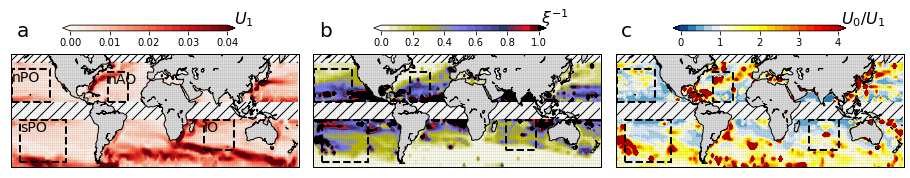

In [33]:
fig=plt.figure(figsize=(16,4))
fs=16
lets=['a','b','c','(d)','(e)','(f)']

map = Basemap(llcrnrlon=-180,llcrnrlat=-57.5,urcrnrlon=180,urcrnrlat=57.5,
              resolution='c',projection='merc')

#m2 = Basemap(projection='moll',lon_0=0,resolution='c')
xmap,ymap=map(llon,llat)

for imap in range(3):
    
    ax=plt.subplot(1,3,imap+1,facecolor='w')
    
    plt.title(lets[imap],loc='left',fontsize=fs+4,y=1.1,x=0.02) 
    
    
    ax.spines['top'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    ax.spines['right'].set_linewidth(1)
    ax.spines['bottom'].set_linewidth(1)
    parallels=np.arange(-60,90,dlon)
    meridians=np.arange(-180,180,dlat)
    map.drawparallels(parallels,labels=[False,False,False,False],fontsize=fs-2,linewidth=0.1)
    map.drawmeridians(meridians,labels=[False,False,False,False],fontsize=fs-2,linewidth=0.1) 
    map.drawcoastlines(zorder=200)
    map.fillcontinents(color='gainsboro',zorder=2)
    
    
    plt.contourf(xmap,ymap,llat_J3,[-11.25,11.25], hatches=['//'],colors='none',rasterized=True,zorder=2)
    plt.contourf(xmap,ymap,llat_J3,[51.25,60], hatches=['///'],colors='none',rasterized=True,zorder=2)

    only_mid=(np.abs(llat)<10)|(llat>51.25)
    
    if imap==0:
        
        
        
        
        toplot=np.where(only_mid,np.nan,U_n_avg_all_ok[1])
        pc=plt.contourf(xmap,ymap,toplot,np.linspace(0,0.04,21),cmap='Reds',extend='both',rasterized=True)
        #pc=plt.pcolormesh(xmap,ymap,toplot,vmin=0,vmax=0.04,cmap='Reds',rasterized=True)

     
        
        
    
        for imask in [0,1,2,3]:
            print(areas[imask])
            show_loc_mask(imask,ax,areas[imask],map)


        cbar_ax = fig.add_axes([0.17, 0.78, 0.15, 0.02])
        cbar=fig.colorbar(pc, cax=cbar_ax,extend='both',orientation='horizontal',ticks=np.arange(0,0.05,0.01))
        cbar_ax.set_title(r'$U_1$', fontsize=fs, x=1.05,y=0.2)
        cbar.ax.yaxis.set_offset_position('right')
        #cbar.formatter.set_powerlimits((0, 0))
        cbar.update_ticks()
        
        
    if imap==2:
        
        
        

        toplot=np.where(only_mid,np.nan,U_n_avg_all_ok[0]/U_n_avg_all_ok[1])
        pc=plt.contourf(xmap,ymap,toplot,np.linspace(0,4.,21),cmap=MYCMP,extend='both',rasterized=True)
        #pc=plt.pcolormesh(xmap,ymap,toplot,vmin=0,vmax=4.,cmap=MYCMP,rasterized=True)


        for imask in [0,1,2,3]:
            print(areas[imask])
            show_loc_mask_noname(imask,ax,areas[imask],map)


        cbar_ax = fig.add_axes([0.7, 0.78, 0.15, 0.02])
        cbar=fig.colorbar(pc, cax=cbar_ax,extend='both',orientation='horizontal',ticks=np.arange(0,5,1))
        cbar_ax.set_title(r'$U_0/U_1$', fontsize=fs, x=1.1,y=0.2)
        cbar.ax.yaxis.set_offset_position('right')
        #cbar.formatter.set_powerlimits((0, 0))
        cbar.update_ticks()
        

    if imap==1:
        
        
        
        toplot=np.where(only_mid,np.nan,xi_inv)
        pc=plt.contourf(xmap,ymap,toplot,np.linspace(0,1.,21),cmap='gist_stern_r',extend='both',rasterized=True)
        #pc=plt.pcolormesh(xmap,ymap,toplot,vmin=0,vmax=1.,cmap='gist_stern_r',rasterized=True)



        for imask in [0,1,2,3]:
            print(areas[imask])
            show_loc_mask_noname(imask,ax,areas[imask],map)


        cbar_ax = fig.add_axes([0.44, 0.78, 0.15, 0.02])
        cbar=fig.colorbar(pc, cax=cbar_ax,extend='both',orientation='horizontal',ticks=np.arange(0,1.1,0.2))
        cbar_ax.set_title(r'$\xi^{-1}$', fontsize=fs, x=1.05,y=0.2)
        cbar.ax.yaxis.set_offset_position('right')
        #cbar.formatter.set_powerlimits((0, 0))
        cbar.update_ticks()



plt.subplots_adjust(hspace=0.01,wspace=0.05)

#plt.savefig('recap_global_maps.png',dpi=300,bbox_inches='tight')

plt.show()